In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
import scipy as sp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras import layers

### In this notebook, we use a compressed version of JLA compilation
#### First, we need to read the data. In this case, we use the covariance matrix of systematic errors 

In [2]:
syscov = np.loadtxt('https://raw.githubusercontent.com/igomezv/neuralCosmoReconstruction/master/data/cov_jla_binned_distances_31nodes_v1.txt?token=AGNUJUJSMOYE4Q2IXMWP26K7SC47M',skiprows=1).reshape((31,31))
# syscov = np.loadtxt('data/jla_v0_covmatrix.dat',skiprows=1).reshape((740,740))

### Verify that there ar not complex numbers and that the matrix is symmetrical

In [3]:
count = 0

for i in range(len(syscov)):
    for j in range(len(syscov)):
        if np.iscomplex(syscov[i,j]):
            print("COMPLEX")
        if syscov[i,j] != syscov[j,i]:
#             print(i,j)
#             print(syscov[i,j], syscov[j,i]) 
            count+=1
            syscov[j,i] = syscov[i, j]

count

0

### Visualization of the covariance matrix:

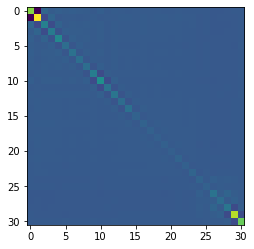

In [4]:
plt.imshow(syscov)


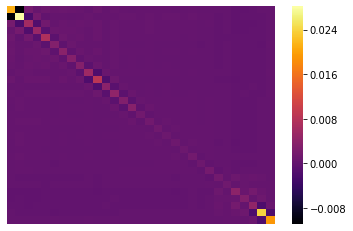

In [5]:
sns.heatmap(pd.DataFrame(syscov), annot=False, fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno')


In [6]:
np.min(syscov), np.max(syscov) #checking non-negatives in the diagonal

(-0.01084098704, 0.02815552265)

### Generate a data set with covariance matrix from the original plus gaussian noise

In [7]:
numMatrix = 100
noise_factor = 1e-2
covset = np.zeros((numMatrix, 31, 31))
for i in range(numMatrix): 
    print("\r Generating {} matrix".format(i+1), end=" ")
    covset[i] = syscov  + noise_factor * np.random.normal(loc=0.0, scale=0.01, size=syscov.shape) 
#     fig = plt.figure(figsize=(6,6))
#     sns.heatmap(pd.DataFrame(pset[i]*maxval), 
#             fmt='g', xticklabels=False, yticklabels=False, 
#             cmap = 'inferno', cbar=False,
#             robust=False)
#     fig.savefig('image/covMatrix_{}.png'.format(i), dpi=300, )
#     plt.clf()

 Generating 100 matrix 

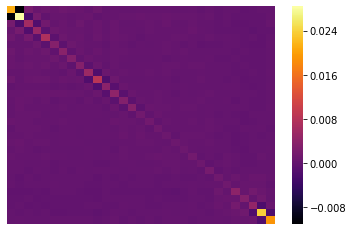

In [8]:
sns.heatmap(pd.DataFrame(covset[i]), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)

In [9]:
print(np.shape(covset))

(100, 31, 31)


(100, 31, 31)


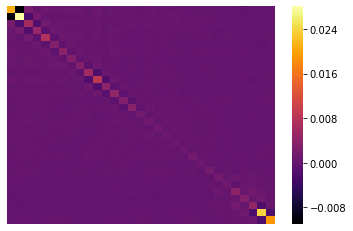

In [10]:
print(np.shape(covset))
split = 0.8
ntrain = int(split * numMatrix)
indx = [ntrain]
covset_train, covset_test = np.split(covset, indx, axis=0)

sns.heatmap(pd.DataFrame(covset_test[0]), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)
covset_train = covset_train.reshape((len(covset_train), np.prod(covset_train.shape[1:])))
covset_test = covset_test.reshape((len(covset_test), np.prod(covset_test.shape[1:])))


In [11]:
# input_cov = Input(shape=(31, 31, 1))

# This is the size of our encoded representations
encoding_dim = 31  

# This is our input image
input_img = tf.keras.Input(shape=(31*31,))
# "encoded" is the encoded representation of the input
x = layers.Dense(100, activation='tanh')(input_img)
# x = layers.Dense(200, activation='relu')(x)
# x = layers.Dense(100, activation='relu')(x)
encoded = layers.Dense(encoding_dim, activation='tanh')(x)
# "decoded" is the lossy reconstruction of the input
# x = layers.Dense(100, activation='relu')(input_img)
# x = layers.Dense(200, activation='relu')(x)
x = layers.Dense(100, activation='tanh')(input_img)
decoded = layers.Dense(31*31, activation='linear')(encoded)

# This model maps an input to its reconstruction
autoencoder = tf.keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 961)]             0         
_________________________________________________________________
dense (Dense)                (None, 100)               96200     
_________________________________________________________________
dense_1 (Dense)              (None, 31)                3131      
_________________________________________________________________
dense_3 (Dense)              (None, 961)               30752     
Total params: 130,083
Trainable params: 130,083
Non-trainable params: 0
_________________________________________________________________


In [12]:
encoder = tf.keras.Model(input_img, encoded)
# This is our encoded (32-dimensional) input
encoded_input = tf.keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = tf.keras.Model(encoded_input, decoder_layer(encoded_input))

In [13]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0,
                                   patience=10, 
                                   restore_best_weights=True)]

autoencoder_train = autoencoder.fit(covset_train, covset_train,
                epochs=100,
                batch_size=32,
                shuffle=True,
                validation_data=(covset_test, covset_test),
                callbacks=callbacks)
#                 callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/100
3/3 [==============================] - 0s 41ms/step - loss: 2.9971e-06 - val_loss: 2.1211e-06
Epoch 2/100
3/3 [==============================] - 0s 8ms/step - loss: 1.8489e-06 - val_loss: 1.2925e-06
Epoch 3/100
3/3 [==============================] - 0s 6ms/step - loss: 1.1709e-06 - val_loss: 7.9820e-07
Epoch 4/100
3/3 [==============================] - 0s 9ms/step - loss: 6.8168e-07 - val_loss: 4.4683e-07
Epoch 5/100
3/3 [==============================] - 0s 6ms/step - loss: 3.9739e-07 - val_loss: 2.3678e-07
Epoch 6/100
3/3 [==============================] - 0s 7ms/step - loss: 1.9398e-07 - val_loss: 1.2920e-07
Epoch 7/100
3/3 [==============================] - 0s 7ms/step - loss: 1.1775e-07 - val_loss: 7.5246e-08
Epoch 8/100
3/3 [==============================] - 0s 6ms/step - loss: 7.2414e-08 - val_loss: 7.7936e-08
Epoch 9/100
3/3 [==============================] - 0s 7ms/step - loss: 7.7028e-08 - val_loss: 7.0115e-08
Epoch 10/100
3/3 [==============================] - 0s

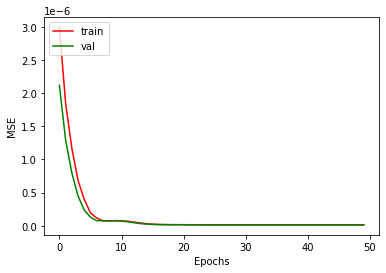

In [14]:
plt.plot(autoencoder_train.history['loss'], color='r', )
plt.plot(autoencoder_train.history['val_loss'], color='g')
# plt.title('model loss function')
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
# plt.savefig('loss_100ep_mse.png')

In [15]:
encoded_imgs = encoder.predict(covset_test)
decoded_imgs = decoder.predict(encoded_imgs)
print(np.shape(encoded_imgs))
df = pd.DataFrame(encoded_imgs)
np.min(encoded_imgs)

(20, 31)


-0.019683067

(20, 961)
266.6666666666667


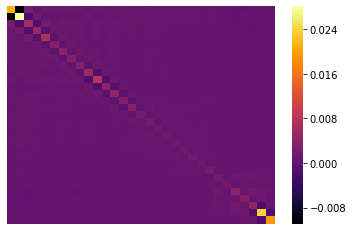

In [16]:
print(np.shape(decoded_imgs))
cte = 0.032/0.00012
print(cte)

sns.heatmap(pd.DataFrame(decoded_imgs[0].reshape(31,31)), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)
# plt.savefig("decoded_img22.png")

In [17]:
print(np.shape(decoded_imgs))

(20, 961)


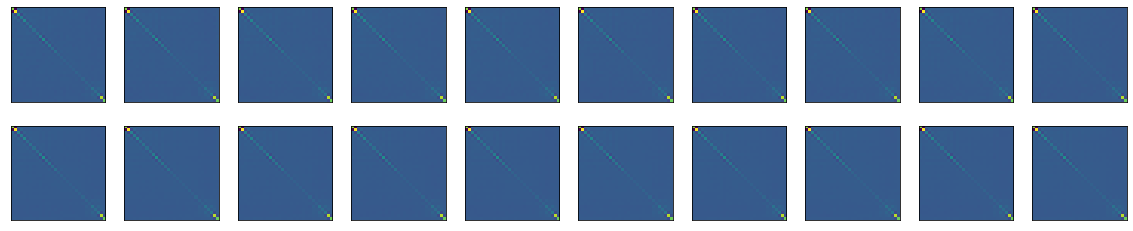

In [18]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(covset_test[i].reshape(31, 31))
#     plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(31, 31))
#     plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

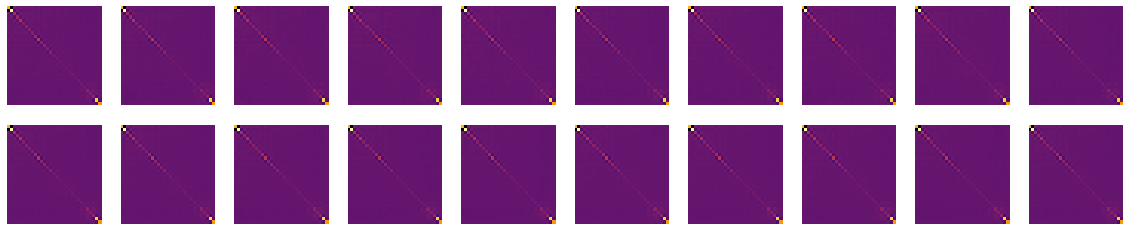

In [19]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    sns.heatmap(covset_test[i].reshape(31, 31), cbar=False, fmt='g', xticklabels=False, yticklabels=False, 
                cmap = 'inferno')
    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    sns.heatmap(decoded_imgs[i].reshape(31, 31), cbar=False, fmt='g', xticklabels=False, yticklabels=False, 
                cmap = 'inferno')
